<a href="https://colab.research.google.com/github/molybdenum-jo/Recommend-Algorithm/blob/main/Book_recommend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers --upgrade --q
!pip install accelerate --q
!pip install datasets --q

In [ ]:
import time
start_time = time.time()
start_time

1682585046.1753964

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
!pip install scikit-surprise


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import pandas as pd
from collections import defaultdict

In [ ]:
base_path = "data"

train = pd.read_csv(f'{base_path}/train.csv')
test = pd.read_csv(f'{base_path}/test.csv')
submission = pd.read_csv(f'{base_path}/sample_submission.csv', index_col='ID')

train.shape, test.shape, submission.shape

((613080, 10), (159621, 9), (159621, 1))

* ID : 샘플 고유 ID
* User-ID : 유저 고유 ID
* Book-ID : 도서 고유 ID
* 유저 정보
* Age : 나이
* Location : 지역
* 도서 정보
* Book-Title : 도서 명
* Book-Author : 도서 저자
* Year-Of-Publication : 도서 출판 년도 (-1일 경우 결측 혹은 알 수 없음):
* Publisher : 출판사
* Book-Rating : 유저가 도서에 부여한 평점 (0점 ~ 10점)

In [ ]:
train.head()

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TRAIN_000000,USER_00000,BOOK_044368,8.0,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
1,TRAIN_000001,USER_00000,BOOK_081205,8.0,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
2,TRAIN_000002,USER_00000,BOOK_086781,0.0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books
3,TRAIN_000003,USER_00000,BOOK_098622,0.0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon
4,TRAIN_000004,USER_00000,BOOK_180810,8.0,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book


In [ ]:
test.head()

,ID,User-ID,Book-ID,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TEST_000000,USER_00008,BOOK_047966,37.0,"vermilion, ohio, usa",Birds of Prey: A Novel of Suspense,J.A. Jance,2002.0,Avon
1,TEST_000001,USER_00008,BOOK_119494,37.0,"vermilion, ohio, usa",Midnight Voices,JOHN SAUL,2003.0,Ballantine Books
2,TEST_000002,USER_00008,BOOK_151775,37.0,"vermilion, ohio, usa",Breaking Free : A Prescription for Personal an...,David M. Noer,1996.0,Jossey-Bass
3,TEST_000003,USER_00008,BOOK_176255,37.0,"vermilion, ohio, usa",Bitter Harvest,Ann Rule,1999.0,Pocket
4,TEST_000004,USER_00008,BOOK_187307,37.0,"vermilion, ohio, usa",Embraced by the Light,Betty J. Eadie,1994.0,Bantam Books


In [ ]:
train.isnull().sum()

ID                     0
User-ID                0
Book-ID                1
Book-Rating            1
Age                    1
Location               1
Book-Title             1
Book-Author            1
Year-Of-Publication    1
Publisher              1
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613080 entries, 0 to 613079
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   613080 non-null  object 
 1   User-ID              613080 non-null  object 
 2   Book-ID              613079 non-null  object 
 3   Book-Rating          613079 non-null  float64
 4   Age                  613079 non-null  float64
 5   Location             613079 non-null  object 
 6   Book-Title           613079 non-null  object 
 7   Book-Author          613079 non-null  object 
 8   Year-Of-Publication  613079 non-null  float64
 9   Publisher            613079 non-null  object 
dtypes: float64(3), object(7)
memory usage: 46.8+ MB


In [ ]:
train.isnull().sum().sum()

8

In [ ]:
test.isnull().sum().sum()

0

In [ ]:
train.dropna(inplace=True)

In [ ]:
train.isnull().sum()

ID                     0
User-ID                0
Book-ID                0
Book-Rating            0
Age                    0
Location               0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

In [ ]:
train['Age'] = train['Age'].astype(int)
train['Year-Of-Publication'] = train['Year-Of-Publication'].astype(int)

<Axes: >

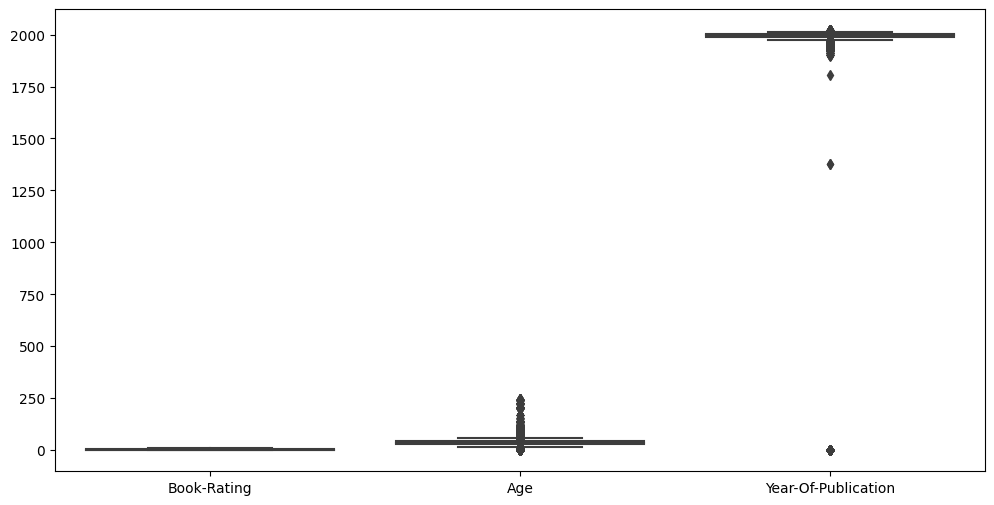

In [ ]:
fig,ax = plt.subplots(figsize=(12,6))
sns.boxplot(data=train)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 613079 entries, 0 to 613078
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   613079 non-null  object 
 1   User-ID              613079 non-null  object 
 2   Book-ID              613079 non-null  object 
 3   Book-Rating          613079 non-null  float64
 4   Age                  613079 non-null  int64  
 5   Location             613079 non-null  object 
 6   Book-Title           613079 non-null  object 
 7   Book-Author          613079 non-null  object 
 8   Year-Of-Publication  613079 non-null  int64  
 9   Publisher            613079 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 51.5+ MB


# EDA

나이별 분포

In [ ]:
max_age = train['Age'].max() # Age 열의 최대값 찾기
min_age = train['Age'].min() # Age 열의 최소값 찾기

print('Maximum Age:', max_age)
print('Minimum Age:', min_age)

Maximum Age: 244
Minimum Age: 0


In [ ]:
iid = 244
train[train["Age"] == iid]

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
604950,TRAIN_604950,USER_63071,BOOK_055682,8.0,244,"stuttgart, baden-wuerttemberg, germany",Die Entdeckung der Currywurst.,Uwe Timm,2000,Dtv
604951,TRAIN_604951,USER_63071,BOOK_096177,0.0,244,"stuttgart, baden-wuerttemberg, germany",Das Blutgericht.,Kari KÃ?Â¶ster-LÃ?Â¶sche,2003,ECON-Taschenbuchverlag
604952,TRAIN_604952,USER_63071,BOOK_148270,0.0,244,"stuttgart, baden-wuerttemberg, germany",Dies Ist Nicht Mein Land,Fleischmann,-1,Wilhelm Heyne Verlag GmbH &amp; Co KG
604953,TRAIN_604953,USER_63071,BOOK_152432,0.0,244,"stuttgart, baden-wuerttemberg, germany",Wer Dornen sÃ?Â¤t.,Rebecca Ryman,2000,"Fischer (Tb.), Frankfurt"
604954,TRAIN_604954,USER_63071,BOOK_245261,8.0,244,"stuttgart, baden-wuerttemberg, germany",Who Put the Pizza in the Vcr: Laughing Your Wa...,Martha Bolton,1996,Gospel Light Pubns
604955,TRAIN_604955,USER_63071,BOOK_254526,0.0,244,"stuttgart, baden-wuerttemberg, germany",Die Tote im falschen Grab.,Ruth Rendell,2000,Goldmann
604956,TRAIN_604956,USER_63071,BOOK_266466,6.0,244,"stuttgart, baden-wuerttemberg, germany",Topkapi.,Eric Ambler,1978,Diogenes Verlag


In [ ]:
train['Age'] = np.where((train['Age'] < 0) | (train['Age'] > 100), np.nan, train['Age'])

# 결측치를 평균값으로 대체하기
mean_Age = train['Age'].mean()
train['Age'] = train['Age'].fillna(mean_Age)

print(train)

                  ID     User-ID      Book-ID  Book-Rating   Age  \
0       TRAIN_000000  USER_00000  BOOK_044368          8.0  23.0   
1       TRAIN_000001  USER_00000  BOOK_081205          8.0  23.0   
2       TRAIN_000002  USER_00000  BOOK_086781          0.0  23.0   
3       TRAIN_000003  USER_00000  BOOK_098622          0.0  23.0   
4       TRAIN_000004  USER_00000  BOOK_180810          8.0  23.0   
...              ...         ...          ...          ...   ...   
613074  TRAIN_613074  USER_64056  BOOK_164028          0.0  35.0   
613075  TRAIN_613075  USER_64056  BOOK_164342          0.0  35.0   
613076  TRAIN_613076  USER_64056  BOOK_164782          9.0  35.0   
613077  TRAIN_613077  USER_64056  BOOK_165556          0.0  35.0   
613078  TRAIN_613078  USER_64056  BOOK_165574          0.0  35.0   

                                Location  \
0       sackville, new brunswick, canada   
1       sackville, new brunswick, canada   
2       sackville, new brunswick, canada   
3      

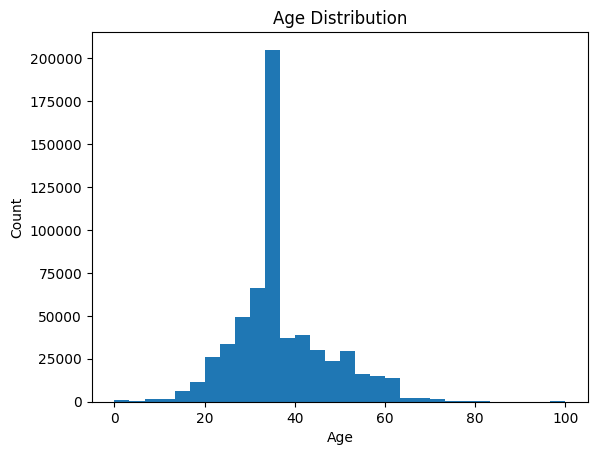

In [ ]:
train['Age'].plot.hist(bins=30) # 히스토그램 그리기
plt.title('Age Distribution') # 그래프 제목 설정
plt.xlabel('Age') # x축 레이블 설정
plt.ylabel('Count') # y축 레이블 설정
plt.show() # 그래프 보이기

출판연도별 분포

In [ ]:
year = -1
train[train["Year-Of-Publication"] == year]

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
184,TRAIN_000184,USER_00049,BOOK_121460,0.0,37.0,"gaylord, michigan, usa",Bxc Blue Bay Mystery,Gertrude Cha Warner,-1,Scholastic Inc
186,TRAIN_000186,USER_00049,BOOK_175661,10.0,37.0,"gaylord, michigan, usa",Lighthouse Mystery,Gertrude C Warner,-1,Scholastic Inc
191,TRAIN_000191,USER_00049,BOOK_230275,0.0,37.0,"gaylord, michigan, usa",Mike's Mystery,Gertrude Cha Warner,-1,Scholastic Inc
231,TRAIN_000231,USER_00054,BOOK_122689,0.0,39.0,"spring, texas, usa",Charming Billy,Alice Mcdermott,-1,"Farrar, Straus Giroux"
290,TRAIN_000290,USER_00060,BOOK_165427,0.0,27.0,"los angeles, california, usa",Moon Palace,Paul Auster,-1,Faber Faber Inc
...,...,...,...,...,...,...,...,...,...,...
612705,TRAIN_612705,USER_64037,BOOK_103002,8.0,49.0,"camberley, surrey, united kingdom",84 Charing Cross Road,Helene Hanff,-1,Warner Books> C/o Little Br
612710,TRAIN_612710,USER_64037,BOOK_171600,0.0,49.0,"camberley, surrey, united kingdom","Life,the Universe and Everything",Douglas Adams,-1,Pan Books Ltd
612734,TRAIN_612734,USER_64049,BOOK_039385,3.0,31.0,"krefeld, nordrhein-westfalen, germany","Herr Der Fliegen (Fiction, Poetry and Drama)",Golding,-1,Fischer Taschenbuch Verlag GmbH
612760,TRAIN_612760,USER_64056,BOOK_011020,0.0,35.0,"summerville, south carolina, usa",More Tales of the City,Maupin,-1,Bantam Doubleday Dell


In [ ]:
train['Year-Of-Publication'] = np.where((train['Year-Of-Publication'] < 1950) | (train['Year-Of-Publication'] > 2023), np.nan, train['Year-Of-Publication'])

# 결측치를 평균값으로 대체하기
mean_Year = train['Year-Of-Publication'].mean()
train['Year-Of-Publication'] = train['Year-Of-Publication'].fillna(mean_Year)

print(train)

                  ID     User-ID      Book-ID  Book-Rating   Age  \
0       TRAIN_000000  USER_00000  BOOK_044368          8.0  23.0   
1       TRAIN_000001  USER_00000  BOOK_081205          8.0  23.0   
2       TRAIN_000002  USER_00000  BOOK_086781          0.0  23.0   
3       TRAIN_000003  USER_00000  BOOK_098622          0.0  23.0   
4       TRAIN_000004  USER_00000  BOOK_180810          8.0  23.0   
...              ...         ...          ...          ...   ...   
613074  TRAIN_613074  USER_64056  BOOK_164028          0.0  35.0   
613075  TRAIN_613075  USER_64056  BOOK_164342          0.0  35.0   
613076  TRAIN_613076  USER_64056  BOOK_164782          9.0  35.0   
613077  TRAIN_613077  USER_64056  BOOK_165556          0.0  35.0   
613078  TRAIN_613078  USER_64056  BOOK_165574          0.0  35.0   

                                Location  \
0       sackville, new brunswick, canada   
1       sackville, new brunswick, canada   
2       sackville, new brunswick, canada   
3      

<Axes: xlabel='Year-Of-Publication', ylabel='Count'>

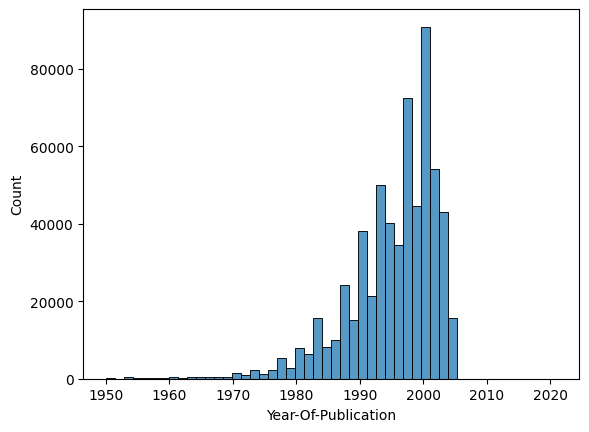

In [ ]:
sns.histplot(train['Year-Of-Publication'], kde=False, bins=50)

<ipython-input-25-0bd63cb06207>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True, annot_kws={'size': 20}) #annot 크기 조정


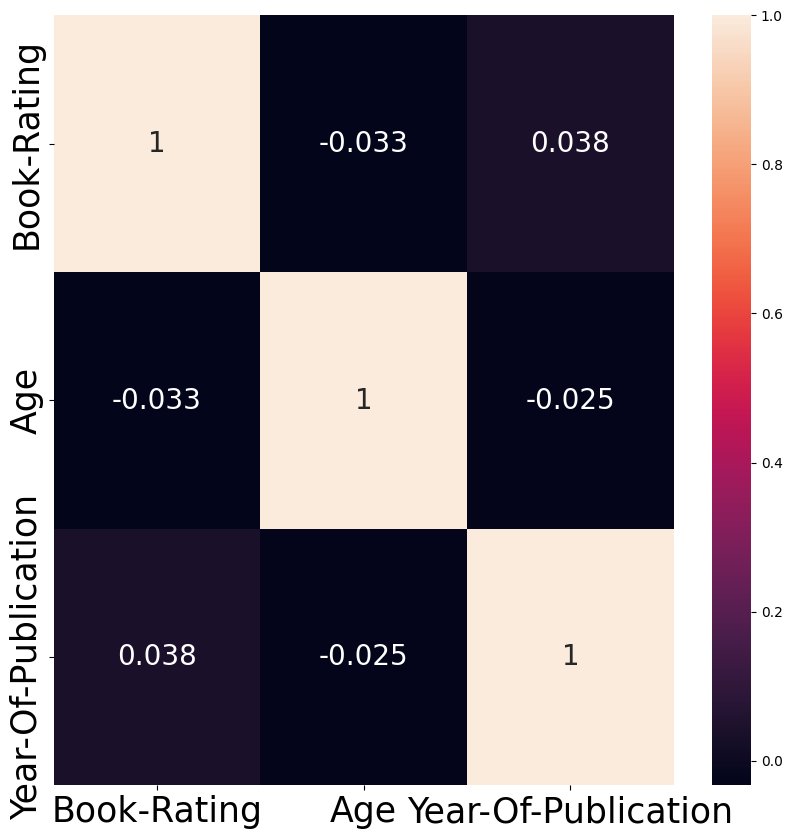

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), annot=True, annot_kws={'size': 20}) #annot 크기 조정
plt.tick_params(labelsize=25)

In [ ]:
train

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TRAIN_000000,USER_00000,BOOK_044368,8.0,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
1,TRAIN_000001,USER_00000,BOOK_081205,8.0,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
2,TRAIN_000002,USER_00000,BOOK_086781,0.0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books
3,TRAIN_000003,USER_00000,BOOK_098622,0.0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon
4,TRAIN_000004,USER_00000,BOOK_180810,8.0,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book
...,...,...,...,...,...,...,...,...,...,...
613074,TRAIN_613074,USER_64056,BOOK_164028,0.0,35.0,"summerville, south carolina, usa",The Secret Life of Bees,Sue Monk Kidd,2002.0,Viking Books
613075,TRAIN_613075,USER_64056,BOOK_164342,0.0,35.0,"summerville, south carolina, usa",Shooting at Loons (Deborah Knott Mysteries (Pa...,Margaret Maron,1995.0,Warner Books
613076,TRAIN_613076,USER_64056,BOOK_164782,9.0,35.0,"summerville, south carolina, usa",Hit List,Lawrence Block,2000.0,William Morrow &amp; Company
613077,TRAIN_613077,USER_64056,BOOK_165556,0.0,35.0,"summerville, south carolina, usa",Going Home,Danielle Steel,1991.0,Pocket


In [ ]:
from geopy.geocoders import Nominatim
import pandas as pd

# 나라와 도시명이 저장된 데이터프레임 생성

# geopy의 Nominatim 객체 생성
geolocator = Nominatim(user_agent='my_application')

# 위도, 경도를 저장할 빈 리스트 생성
latitudes = []
longitudes = []

# 각 도시별 위도와 경도를 구하여 리스트에 저장
for index, row in train.iterrows():
    location = geolocator.geocode(row['City'] + ', ' + row['Country'])


KeyError: ignored

In [ ]:
import folium

# City, State, Country 열 추가하기
location_split = train['Location'].str.split(', ', expand=True)
train[['City', 'State', 'Country']] = location_split

# 지도에 마커 추가하기
m = folium.Map(location=[0, 0], zoom_start=2)
for i, row in train.iterrows():
    city = row['City']
    state = row['State']
    country = row['Country']
    tooltip = f"{city}, {state}, {country}"
    location = f"{city}, {country}"
    try:
        geocode = geolocator.geocode(location)
        latitude = geocode.latitude
        longitude = geocode.longitude
        folium.Marker(
            location=[latitude, longitude],
            tooltip=tooltip
        ).add_to(m)
    except:
        pass

m


ValueError: ignored

In [ ]:
df_valid = train[train["ID"].notnull() & 
                  (train["Year-Of-Publication"] > 0) & 
                  (train["Age"] > 0) ].copy()
df_valid = df_valid.drop_duplicates()
df_valid.shape

(612733, 10)

In [ ]:
df = train[["ID", "Book-ID", "Book-Rating"]].drop_duplicates().sample(100000, random_state=42)
print(df.shape)
df.head()

(100000, 3)


,ID,Book-ID,Book-Rating
307878,TRAIN_307878,BOOK_017424,0.0
501963,TRAIN_501963,BOOK_214393,0.0
458986,TRAIN_458986,BOOK_188259,0.0
485362,TRAIN_485362,BOOK_213362,8.0
387219,TRAIN_387219,BOOK_250100,8.0


In [ ]:
r_min = df["Book-Rating"].min()
r_max = df["Book-Rating"].max()
r_min, r_max

(0.0, 10.0)

In [ ]:
reader = Reader(rating_scale=(r_min, r_max))
reader

In [ ]:
data = Dataset.load_from_df(
    df[["ID", "Book-ID", "Book-Rating"]], 
    reader)
data

In [ ]:
from surprise.model_selection import train_test_split

X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
X_train.n_users, X_train.n_items, X_train.n_ratings

(80000, 49168, 80000)

In [ ]:
X_train

In [ ]:
type(X_test), len(X_test)

(list, 20000)

In [ ]:
from surprise.prediction_algorithms.knns import KNNBasic
# model

knn = KNNBasic(name="cosine", user_base=True)
knn.fit(X_train)

In [ ]:
predictions = knn.test(X_test)

In [ ]:
X_test[3]

In [ ]:
predictions[3]

In [ ]:
df["Book-Rating"].describe()

In [ ]:
accuracy.rmse(predictions)

In [ ]:
df.sample()

In [ ]:
iid = "BOOK_011665"
df[df["Book-ID"] == iid]

In [ ]:
uid = 'USER_44609'
iid = "BOOK_011665"
df[(df["User-ID"] == uid) & (df["Book-ID"] == iid)]

In [ ]:
knni = KNNBasic(name="cosine", user_base=False)
knni.fit(X_train)

In [ ]:
predictions_item = knni.test(X_test)

In [ ]:
accuracy.rmse(predictions_item)

In [ ]:
df.iloc[3]

# SVD

In [ ]:
svd = SVD(random_state=42)
svd.fit(X_train)

In [ ]:
predictions_svd = svd.test(X_test)

In [ ]:
predictions_svd[1]

In [ ]:
accuracy.rmse(predictions_svd)

In [ ]:
for pred in predictions_svd:
    uid = pred.uid
    r_ui = pred.iid
    rating = pred.est
    df_submit.loc[(df_submit['ID'] == uid) & (df_submit['Book-Rating'] == r_ui), 'Book-Rating'] = rating


In [ ]:
df_submit = pd.read_csv(f"{base_path}/sample_submission.csv")
df_submit.head()

In [ ]:
df_submit["Book-Rating"] = abs(pred)
df_submit.head(2)

In [ ]:
uid = 'USER_44609'
iid = "BOOK_011665"
display(df[(df["User-ID"] == uid) & (df["Book-ID"] == iid)])
svd.predict(uid, iid, 6)

In [ ]:
from surprise.model_selection import GridSearchCV, cross_validate

# GridSearchCV는 cross_validate와는 달리 인자에 알고리즘 자체를 매개변수로 받는다.
# param_grid = {'n_factors': [50, 75], 
#               'lr_all': [0.5, 0.05], 
#               'reg_all': [0.06, 0.04]} 
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

gridcv = GridSearchCV(algo_class=SVD, 
                      param_grid=param_grid, 
                      measures=["rmse"], cv=3)
gridcv.fit(data)

In [ ]:
gridcv.best_estimator

In [ ]:
gridcv.best_params["rmse"]

In [ ]:
gridcv.best_score

In [ ]:
gridcv.algo_class

In [ ]:
best_svd = gridcv.best_estimator["rmse"]
best_svd.fit(X_train)

In [ ]:
predictions_bsvd = best_svd.test(X_test)

In [ ]:
predictions_bsvd[0]

In [ ]:
accuracy.rmse(predictions_bsvd)

In [ ]:
df_pred_svd = pd.DataFrame(predictions_bsvd)
df_pred_svd.head()

In [ ]:
df_pred_svd["est"].unique()

In [ ]:
cv_result = cross_validate(best_svd, data, measures=["rmse"], n_jobs=2, verbose=True)

In [ ]:
pd.DataFrame(cv_result)

In [ ]:
def get_top_n(predictions, n=10):
    # 각 사용자의 예측데이터를 defaultdict에 저장
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # 정렬 후 Top N 개만 저장
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_num = get_top_n(predictions_bsvd, 10)

In [ ]:
df_cust_recomm = pd.DataFrame(top_num.items())

In [ ]:
df_cust_recomm.head()

In [ ]:
stock_desc = df_valid[
    ["ID", "Book-Rating"]].drop_duplicates("ID").set_index("ID")
stock_desc

In [ ]:
df_submit = pd.read_csv(f"{base_path}/sample_submission.csv")
df_submit.head()

In [ ]:
submit['Book-Rating'] = test.apply(lambda row: stock_desc.predict(row['User-ID'], row['Book-ID']).est, axis=1)

In [ ]:
stock_desc.to_csv(file_name)
pd.read_csv(file_name).head(2)

,ID,Book-Rating
0,TRAIN_000000,8.0
1,TRAIN_000001,8.0


In [ ]:
file_name = f"{base_path}/submit.csv"
file_name

'data/submit.csv'

In [ ]:
from google.colab import files

files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train[categorical_feature] = train[categorical_feature].astype("category")
test[categorical_feature] = test[categorical_feature].astype("category")

train.info(), test.info()

NameError: ignored

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train[categorical_feature] = oe.fit_transform(train[categorical_feature])
test[categorical_feature] = oe.transform(test[categorical_feature])

In [ ]:
from sklearn.model_selection import train_test_split

# X_train, X_valid, y_train, y_valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((551771, 8), (61308, 8), (551771,), (61308,))

In [ ]:
X = train.drop(columns="Book-Rating")
y = train["Book-Rating"]

X.shape, y.shape

((613079, 8), (613079,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size = 0.1, random_state=42
)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((551771, 8), (61308, 8), (551771,), (61308,))

In [ ]:
X_test = test
X_test.shape

(159621, 8)

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=250, 
                             max_depth=3,
                             random_state=42, 
                             n_jobs=-1)
                             
model_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
dtrain = xgb.DMatrix(X, label=y)

In [ ]:
from xgboost.callback import EarlyStopping
# fit
es = xgb.callback.EarlyStopping(
    rounds=2,
    save_best=True,
    maximize=False,
    data_name="validation_0",
    metric_name="rmse",
)

model_xgb.fit(X_train, y_train, 
              eval_set=[(X_valid, y_valid)], callbacks=[es])

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:4.16758
[1]	validation_0-rmse:3.98705
[2]	validation_0-rmse:3.88902
[3]	validation_0-rmse:3.84286
[4]	validation_0-rmse:3.81827
[5]	validation_0-rmse:3.80099
[6]	validation_0-rmse:3.79127
[7]	validation_0-rmse:3.78691
[8]	validation_0-rmse:3.78307
[9]	validation_0-rmse:3.77965
[10]	validation_0-rmse:3.77456
[11]	validation_0-rmse:3.76810
[12]	validation_0-rmse:3.76504
[13]	validation_0-rmse:3.76347
[14]	validation_0-rmse:3.75937
[15]	validation_0-rmse:3.75649
[16]	validation_0-rmse:3.75359
[17]	validation_0-rmse:3.75229
[18]	validation_0-rmse:3.75130
[19]	validation_0-rmse:3.75043
[20]	validation_0-rmse:3.74577
[21]	validation_0-rmse:3.74200
[22]	validation_0-rmse:3.74040
[23]	validation_0-rmse:3.73734
[24]	validation_0-rmse:3.73326
[25]	validation_0-rmse:3.73277
[26]	validation_0-rmse:3.73202
[27]	validation_0-rmse:3.73075
[28]	validation_0-rmse:3.72966
[29]	validation_0-rmse:3.72799
[30]	validation_0-rmse:3.72745
[31]	validation_0-rmse:3.72651
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
y_valid_predict = model_xgb.predict(X_valid)
y_valid_predict[:5]

array([2.6720324, 2.3510609, 2.7579746, 2.02187  , 3.039866 ],
      dtype=float32)

<Axes: >

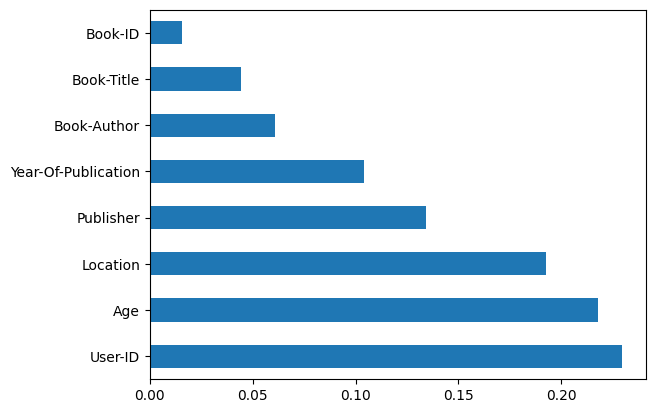

In [ ]:
fi = pd.Series(model_xgb.feature_importances_)
fi.index = model_xgb.feature_names_in_
fi.nlargest(20).plot.barh()

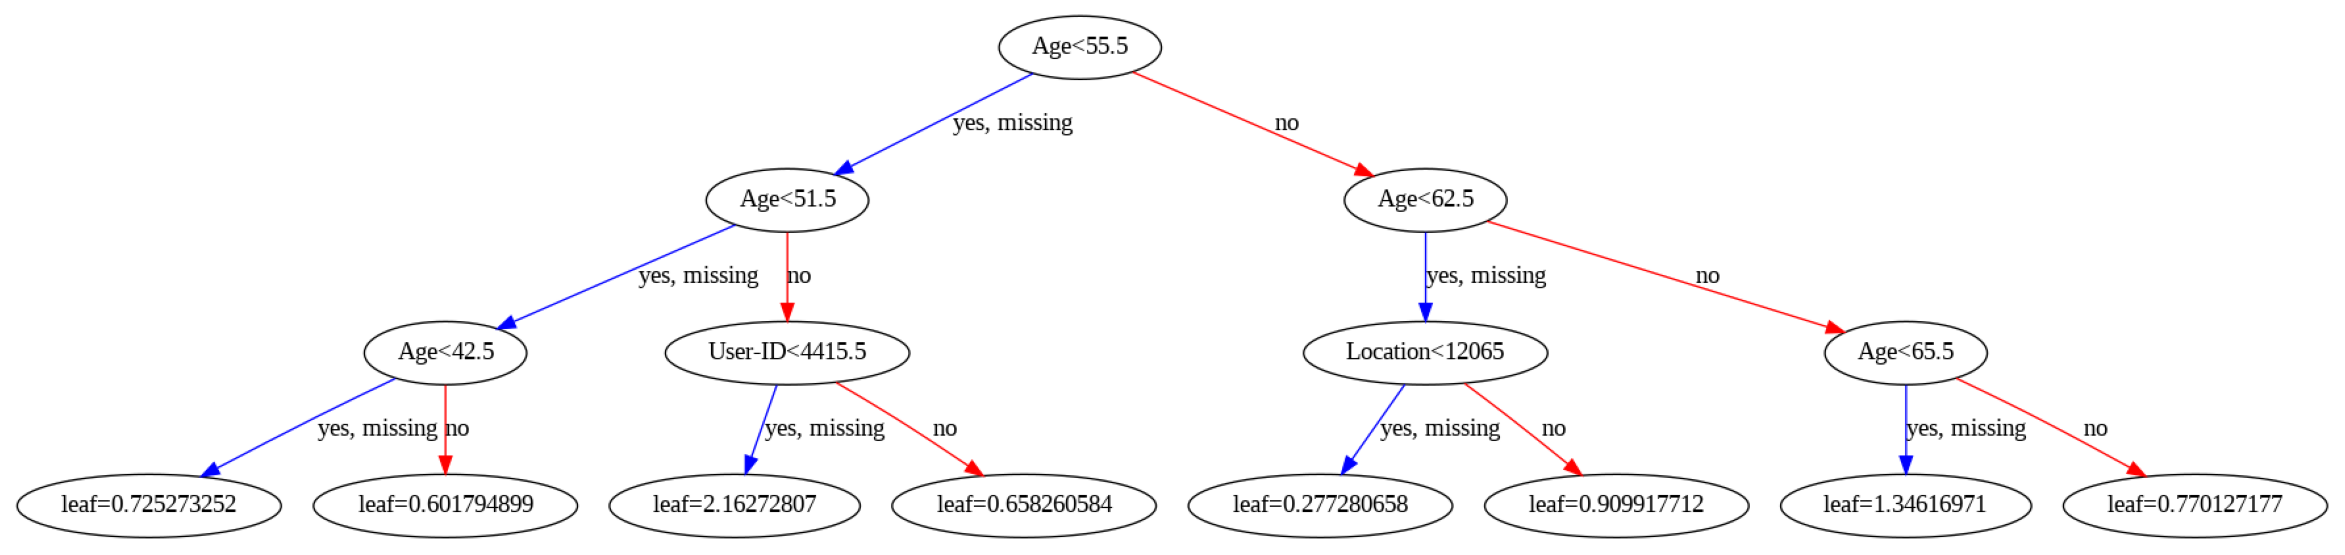

In [ ]:
xgb.plot_tree(model_xgb, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(30, 20)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_valid, y_valid_predict)

0.1331875875106453

In [ ]:
score_xgb = model_xgb.score(X_valid, y_valid)
score_xgb

0.1331875875106453

In [ ]:
X_test.shape

(159621, 8)

In [ ]:
y_pred_xgb = model_xgb.predict(X_test)
y_pred_xgb[:5]

array([4.869337 , 4.23094  , 3.8241084, 2.181595 , 4.0882525],
      dtype=float32)

In [ ]:
df_submit = pd.read_csv(f"{base_path}/sample_submission.csv")
df_submit.head()

,ID,Book-Rating
0,TEST_000000,0
1,TEST_000001,0
2,TEST_000002,0
3,TEST_000003,0
4,TEST_000004,0


In [ ]:
df_submit["Book-Rating"] = abs(y_pred_xgb)
df_submit.head(2)

,ID,Book-Rating
0,TEST_000000,4.869337
1,TEST_000001,4.230940


In [ ]:
file_name = f"{base_path}/submit.csv"
file_name

'data/submit.csv'